In [ ]:
# Optional: setup NoTexBook theme
%load_ext notexbook
%texify -fs 18

**Adapted from**: [Ch4](https://github.com/uvm-plaid/programming-dp/blob/master/notebooks/ch4.ipynb)

# Properties of Differential Privacy

In this notebook we will mention three important properties of **differentially private mechanisms** that arise from the definition
 of differential privacy.

These properties are mentioned as they will be used / referenced when we will start generalising DP applications 
to Machine Learning algorithms.


These three properties are:

1. Sequential composition
2. Parallel composition
3. Post processing

## Sequential Composition

The first major property of differential privacy is *sequential composition*, which **bounds** the total 
privacy cost of releasing multiple results of differentially private mechanisms **on the same input data**. 

Formally, the sequential composition theorem for differential privacy says that:

- If $F_1(x)$ satisfies $\epsilon_1$-differential privacy
- And $F_2(x)$ satisfies $\epsilon_2$-differential privacy
- Then the mechanism $G(x) = (F_1(x), F_2(x))$ which releases both results satisfies $\epsilon_1+\epsilon_2$-differential privacy


Sequential composition is a vital property of differential privacy because it enables the design of algorithms that consult the data more than once. 

Sequential composition is also important when multiple separate analyses are performed on a single dataset, since it allows individuals to bound the *total* privacy cost they incur by participating in all of these analyses.

The bound on privacy cost given by sequential composition is an *upper* bound - the actual privacy cost of two particular differentially private releases may be smaller than this, but never larger.

The principle that the $\epsilon$-s "add up" makes sense if we examine the distribution of outputs from a mechanism which averages two differentially private results together.

However, please bear in mind that Sequential composition does not provide an **exact** upper bound: the exact total privacy cost can be indeed lower than the upper bound!.

## Parallel Composition

The second important property of differential privacy is called *parallel composition*. 

Parallel composition can be seen as an alternative to sequential composition - a second way to calculate a bound on the total privacy cost of multiple data releases. 

Parallel composition is based on the idea of **splitting** your dataset into disjoint chunks and running a 
differentially private mechanism on each chunk separately. 

Since the chunks are **disjoint**, each individual's data appears in *exactly* one chunk - so even if there are $k$ chunks in total (and therefore $k$ runs of the mechanism), the mechanism runs exactly once on the data of each *individual*. 

Formally,
 - If $F(x)$ satisfies $\epsilon$-differential privacy
 - And we split a dataset $X$ into $k$ disjoint chunks such that $x_1 \cup ... \cup x_k = X$
 - Then the mechanism which releases all of the results $F(x_1), ..., F(x_k)$ satisfies $\epsilon$-differential privacy

Note that this is a much better bound than sequential composition would give. 

Since we run $F$ $k$ times, sequential composition would say that this procedure satisfies $k\epsilon$-differential privacy. 

Parallel composition allows us to say that the total privacy cost is just $\epsilon$.

The formal definition matches up with our intuition - if each participant in the dataset contributes one row to $X$, then this row will appear in *exactly* one of the chunks $x_1, ..., x_k$. 

That means $F$ will only "see" this participant's data *one time*, meaning a privacy cost of $\epsilon$ is appropriate for that individual. Since this property holds for all individuals, the privacy cost is $\epsilon$ for everyone.

### Histograms

In our context, a *histogram* is an analysis of a dataset which splits the dataset into "bins" based on the value of one of the data attributes, and **counts** the number of rows in each bin. 

For example, a histogram might count the number of people in the dataset who achieved a particular educational level.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
DATASET_URL = "https://raw.githubusercontent.com/uvm-plaid/programming-dp/master/notebooks/adult_with_pii.csv"
adult = pd.read_csv(DATASET_URL)

adult['Education'].value_counts().to_frame().head(5)

,Education
HS-grad,10501
Some-college,7291
Bachelors,5355
Masters,1723
Assoc-voc,1382


Histograms are particularly interesting for differential privacy because they automatically satisfy parallel composition. 

Each "bin" in a histogram is defined by a possible value for a data attribute (for example, `'Education' == 'HS-grad'`). 

It's impossible for a single row to have *two* values for an attribute simultaneously, so defining the bins this way *guarantees* that they will be disjoint. 

Thus we have satisfied the requirements for parallel composition, and we can use a differentially private mechanism to release *all* 
of the bin counts with a total privacy cost of just $\epsilon$.

In [4]:
epsilon = 1
sensitivity = 1

# This analysis has a total privacy cost of epsilon = 1, even though we release many results!
f = lambda x: x + np.random.laplace(loc=0, scale=sensitivity/epsilon)
s = adult['Education'].value_counts().apply(f)
s.to_frame().head(5)

,Education
HS-grad,10501.517591
Some-college,7291.439707
Bachelors,5353.242959
Masters,1720.979196
Assoc-voc,1384.374996


## Optional: Sensitivity and Clipping

### Sensitivity

When discussing the Laplace mechanism, we mentioned that the amount of **noise** that is necessary to ensure differential privacy for 
a given query depends on the *sensitivity* of the query. 

Roughly speaking, the sensitivity of a function reflects the amount the function's output will change when its input changes. 

Recall that the Laplace mechanism defines a mechanism $F(x)$ as follows:

\begin{align}
F(x) = f(x) + \textsf{Lap}\left(\frac{s}{\epsilon}\right)
\end{align}

where $f(x)$ is a deterministic function (the query), $\epsilon$ is the privacy parameter, and $s$ is the sensitivity of $f$.

For a function $f : \mathcal{D} \rightarrow \mathbb{R}$ mapping datasets ($\mathcal{D}$) to real numbers, the *global sensitivity* of $f$ is defined as follows:

\begin{align}
GS(f) = \max_{x, x': d(x,x') <= 1} |f(x) - f(x')|
\end{align}

Here, $d(x, x')$ represents the *distance* between two datasets $x$ and $x'$, and we say that two datasets are *neighbors* if their distance is 1 or less. 

How this distance is defined has a huge effect on the definition of privacy we obtain.

The definition of global sensitivity says that for *any two* neighboring datasets $x$ and $x'$, the difference between $f(x)$ and $f(x')$ is at most $GS(f)$. 

**Global vs Local Sensitivity**:

This measure of sensitivity is called "global" because it is independent of the actual dataset being queried (it holds for *any* choice of neighboring $x$ and $x'$). 

Another measure of sensitivity, called *local sensitivity*, fixes one of the datasets to be the one being queried.

### Distance

The distance metric $d(x,x')$ described earlier can be defined in many different ways. Intuitively, the distance between two datasets should be equal to 1 (i.e. the datasets are neighbors) if they differ in the data of exactly one individual. 

This idea is easy to formalize in some contexts (e.g. in the US Census, each individual submits a single response containing their data) but extremely challenging in others (e.g. location trajectories, social networks, and time-series data).

A common formal definition for datasets containing rows is to consider the number of rows which differ between the two. 

When each individual's data is contained in a single row, this definition often makes sense. Formally, this definition of distance is encoded as a **symmetric difference** between the two datasets:

\begin{align}
d(x, x') = | x - x' \cup x' - x |
\end{align}

This particular definition has several interesting and important implications:
- If $x'$ is constructed from $x$ by *adding one row*, then $d(x,x') = 1$
- If $x'$ is constructed from $x$ by *removing one row*, then $d(x,x') = 1$
- If $x'$ is constructed from $x$ by *modifying one row*, then $d(x,x') = 2$

In other words, adding or removing a row results in a neighboring dataset; *modifying* a row results in a dataset at distance *2*. 

This particular definition of distance results in what is typically called *unbounded differential privacy*. Many other definitions are possible, including one called *bounded differential privacy* in which modifying a single row in a dataset *does* result in a neighboring dataset. 

For now, we will stick to the formal definition defined above in terms of symmetric difference. We will discuss alternative definitions in a later section.

#### Calculating Sensitivity

How do we determine the sensitivity of a particular function of interest? For some simple functions on real numbers, the answer is obvious.

- The global sensitivity of $f(x) = x$ is 1, since changing $x$ by 1 changes $f(x)$ by 1
- The global sensitivity of $f(x) = x+x$ is 2, since changing $x$ by 1 changes $f(x)$ by 2
- The global sensitivity of $f(x) = 5*x$ is 5, since changing $x$ by 1 changes $f(x)$ by 5
- The global sensitivity of $f(x) = x*x$ is unbounded, since the change in $f(x)$ depends on the value of $x$

For functions that map datasets to real numbers, we can perform a similar analysis. We will consider the functions which represent common aggregate database queries: counts, sums, and averages.

#### Counting Queries

Counting queries (`COUNT` in SQL) count the number of rows in the dataset which satisfy a specific property. 

As a rule of thumb, **counting queries always have a sensitivity of 1**. 

This is because adding a row to the dataset can increase the output of the query by at most 1: either the new row has the desired property, and the count increases by 1, or it does not, and the count stays the same (the count may correspondingly decrease when a row is removed).

**Example: "How many people are in the dataset?"** (sensitivity: 1 - counting rows where the property = True)

In [5]:
adult.shape[0]

32561

**Example: "How many people have an educational status above 10?"** (sensitivity: 1 - counting rows with a property)

In [6]:
adult[adult['Education-Num'] > 10].shape[0]

10516

**Example: "How many people have an educational status equal to or below 10?"** (sensitivity: 1 - counting rows with a property)

In [7]:
adult[adult['Education-Num'] <= 10].shape[0]

22045

**Example: "How many people are named Joe Near?"** (sensitivity: 1 - counting rows with a property)

In [8]:
adult[adult['Name'] == 'Joe Near'].shape[0]

0

#### Summation Queries

Summation queries (`SUM` in SQL) sum up the *attribute values* of dataset rows.

**Example: "What is the sum of the ages of people with an educational status above 10?"**

In [9]:
adult[adult['Education-Num'] > 10]['Age'].sum()

422876

Sensitivity for these queries is not **as simple as it is for counting queries**. 

Adding a new row to the dataset will increase the result of our example query by the *age of the new person*. 

That means the sensitivity of the query depends on the **contents** of the row we add.

As a rule of thumb, summation queries have **unbounded sensitivity** when no lower and upper bounds exist on the value of the attribute being summed. 

When lower and upper bounds do exist, the sensitivity of a summation query is equal to the **difference between them**. 

In the next section, we will see a technique called **clipping** for enforcing bounds when none exist, so that summation queries with unbounded sensitivity can be converted into queries with bounded sensitivity.

#### Average Queries

Average queries (`AVG` in SQL) calculate the mean of attribute values in a particular column.

**Example: "What is the average age of people with an educational status above 10?"**

In [16]:
adult[adult['Education-Num'] > 10]['Age'].mean()

40.21262837580829

The easiest way to answer an average query with differential privacy is by re-phrasing it as two queries: a summation query divided by a counting query. For the above example:

In [17]:
adult[adult['Education-Num'] > 10]['Age'].sum() / adult[adult['Education-Num'] > 10]['Age'].shape[0]

40.21262837580829

The sensitivities of both queries can be calculated as described above. 

Noisy answers for each can be calculated (e.g. using the Laplace mechanism) and the noisy answers can be divided to obtain a differentially private mean. 

The total privacy cost of both queries can be calculated by **sequential composition**.

### Clipping

Queries with unbounded sensitivity cannot be directly answered with differential privacy using the Laplace mechanism. 

Fortunately, we can often transform such queries into equivalent queries with *bounded* sensitivity, via a process called **clipping**.

The basic idea behind clipping is to **enforce** upper and lower bounds on attribute values. 

> For example, ages above 125 can be "clipped" to exactly 125. 

After clipping has been performed, we are **guaranteed** that all ages will be 125 or below. 

As a result, the sensitivity of a summation query on clipped data is equal to the difference between the upper and lower bounds used in clipping: $upper - lower$. 

For example, the following query has a sensitivity of 125:

In [18]:
adult['Age'].clip(lower=0, upper=125).sum()

1256257

The primary challenge in performing clipping is to determine the **upper** and **lower** bounds. 

Furthermore, there is a tradeoff between the amount of information lost in clipping and the amount of noise needed to ensure differential privacy. 

As a rule of thumb, **try to set the clipping bounds to include 100% of the dataset**, or get as close as possible. This is harder in some domains (e.g. graph queries) than others.

It's tempting to determine the clipping bounds by looking at the data. For example, we can look at the histogram of ages in our dataset to determine an appropriate upper bound:

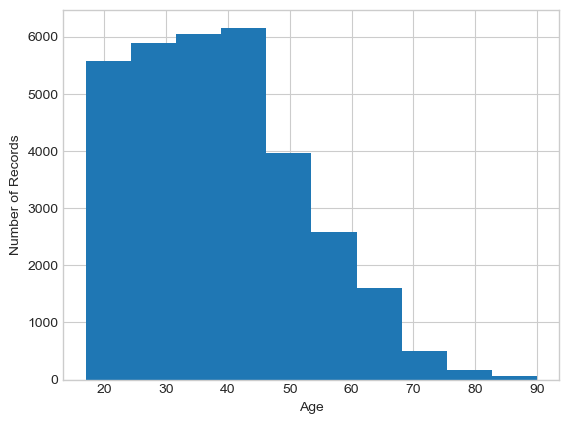

In [19]:
plt.hist(adult['Age'])
plt.xlabel('Age')
plt.ylabel('Number of Records');

It's clear from this histogram that nobody in this particular dataset is over 90, so an upper bound of 90 would suffice.

**NOTE**: However, it's important to note that **this approach does not satisfy differential privacy**. 

If we pick our clipping bounds by looking at the data, then the bounds themselves might reveal something about the data.

Typically, clipping bounds are decided either by using a property of the dataset that can be known without looking at the data (e.g. that the dataset contains ages, which are likely to lie between 0 and 125), or by performing **differentially private queries** to evaluate different choices for the clipping bounds.

**Determine Upper bound with differentially private queries**:

To use the second approach, we typically set the lower bound to 0 and slowly increase the upper bound until the query's output stops changing (meaning we haven't included any new data by increasing the bound). 

For example, let's try computing the sum of ages for clipping bounds `from 0 to 100``, using the Laplace mechanism for each one to ensure differential privacy:

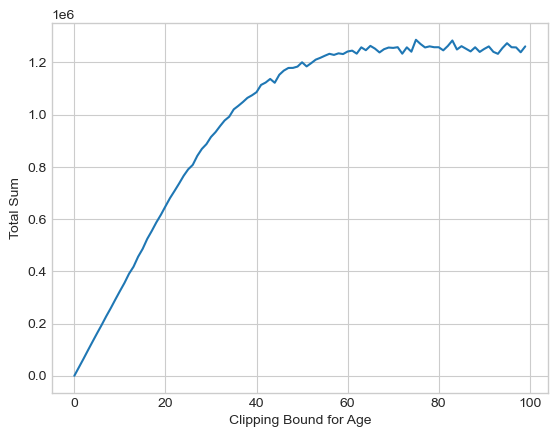

In [20]:
def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity/epsilon)

epsilon_i = .01
plt.plot([laplace_mech(adult['Age'].clip(lower=0, upper=i).sum(), i, epsilon_i) for i in range(100)])
plt.xlabel('Clipping Bound for Age')
plt.ylabel('Total Sum');

The total privacy cost for building this plot is $\epsilon = 1$ by sequential composition, since we do 100 queries each with $\epsilon_i = 0.01$. It's clear that the results level off around a value of `upper = 80`, so this is a good choice for the clipping bound.

One refinement that **can work well when the scale of the data is not known** is to test upper bounds according to a logarithmic scale.